## Creating Connection

In [7]:
# Define Neo4j connections

import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import plotly.graph_objects as go
from itertools import combinations

from networkx.algorithms import community
from sklearn.metrics.pairwise import cosine_similarity

import mysql.connector
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# Create Neo4j Connection

host = 'bolt://34.234.223.89:7687'
user = 'neo4j'
password = 'coils-shocks-gages'
driver = GraphDatabase.driver(host, auth=(user, password))

## Adding Data - (dont run this)

In [3]:
import_queries = """

CALL apoc.schema.assert({Character:['name']},{Comic:['id'], Character:['id'], Event:['id'], Group:['id']});

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroes.csv" as row
CREATE (c:Character)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/groups.csv" as row
CREATE (c:Group)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/events.csv" as row
CREATE (c:Event)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/comics.csv" as row
CREATE (c:Comic)
SET c += apoc.map.clean(row,[],["null"]);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroToComics.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (co:Comic{id:row.comic})
MERGE (c)-[:APPEARED_IN]->(co);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroToEvent.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (e:Event{id:row.event})
MERGE (c)-[:PART_OF_EVENT]->(e);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroToGroup.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (g:Group{id:row.group})
MERGE (c)-[:PART_OF_GROUP]->(g);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroToHero.csv" as row
MATCH (s:Character{id:row.source})
MATCH (t:Character{id:row.target})
CALL apoc.create.relationship(s,row.type, {}, t) YIELD rel
RETURN distinct 'done';

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroStats.csv" as row
MATCH (s:Character{id:row.hero})
CREATE (s)-[:HAS_STATS]->(stats:Stats)
SET stats += apoc.map.clean(row,['hero'],[]);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroFlight.csv" as row
MATCH (s:Character{id:row.hero})
SET s.flight = row.flight;

MATCH (s:Stats)
WITH keys(s) as keys LIMIT 1
MATCH (s:Stats)
UNWIND keys as key
CALL apoc.create.setProperty(s, key, toInteger(s[key]))
YIELD node
RETURN distinct 'done';
"""

In [ ]:
"""
# Establish a session with the Neo4j database using the provided driver
# Split the import_queries string into individual statements using ';' as the delimiter
# Execute each statement within the session context after stripping leading and trailing whitespace

with driver.session() as session:
    for statement in import_queries.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass
"""

## Run Query

In [3]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [4]:
def run_query_with_params(query, params):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

## Exploratory graph analysis

In [5]:
# Nummber of comic appearances 

run_query("""
            MATCH (c:Character)
            RETURN c.name as character, 
                   count{ (c)-[:APPEARED_IN]->() } as comics
            ORDER BY comics DESC
            LIMIT 10
                        """)

character  comics
0                 Spider-Man (1602)    3357
1                        Tony Stark    2354
2                             Logan    2098
3                      Steve Rogers    2019
4  Thor (Marvel: Avengers Alliance)    1547
5                          Hulk-dok    1433
6                      Johnny Storm    1151
7                   Matthew Murdock     999
8                           Cyclops     851
9             Thing (Marvel Heroes)     842

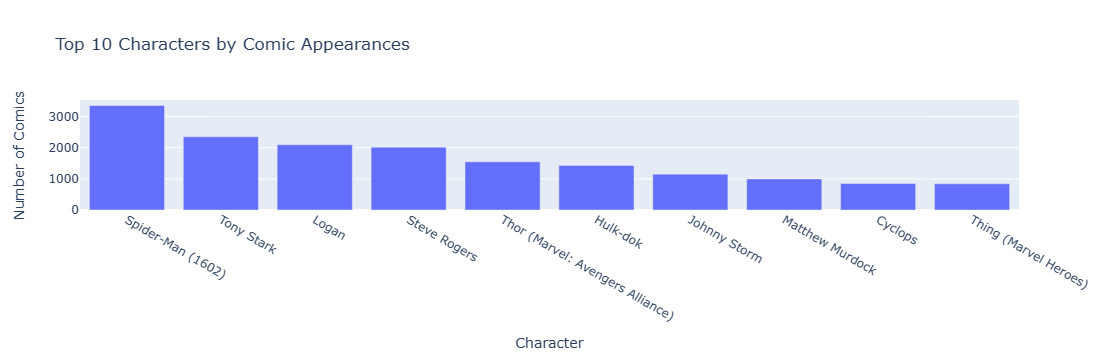

In [6]:
# Call the 'run_query' function with the Cypher query
result_df = run_query("""
                        MATCH (c:Character)
                        RETURN c.name as character, 
                               count{ (c)-[:APPEARED_IN]->() } as comics
                        ORDER BY comics DESC
                        LIMIT 10
                                    """)

fig = px.bar(result_df, x='character', y='comics', title='Top 10 Characters by Comic Appearances')
fig.update_layout(xaxis_title='Character', yaxis_title='Number of Comics')
fig.show()

In [7]:
# Comic releases through the years

run_query("""
                MATCH (c:Comic)
                RETURN substring(c.year, 0, 3) + "0" as decade, 
                       count(*) as count
                ORDER BY decade ASC
                                        """)

decade  count
0    1930     95
1    1940    584
2    1950    756
3    1960   4114
4    1970   1956
5    1980   2428
6    1990   3738
7    2000   8309
8    2010  11139
9    2020     19
10   None   5737

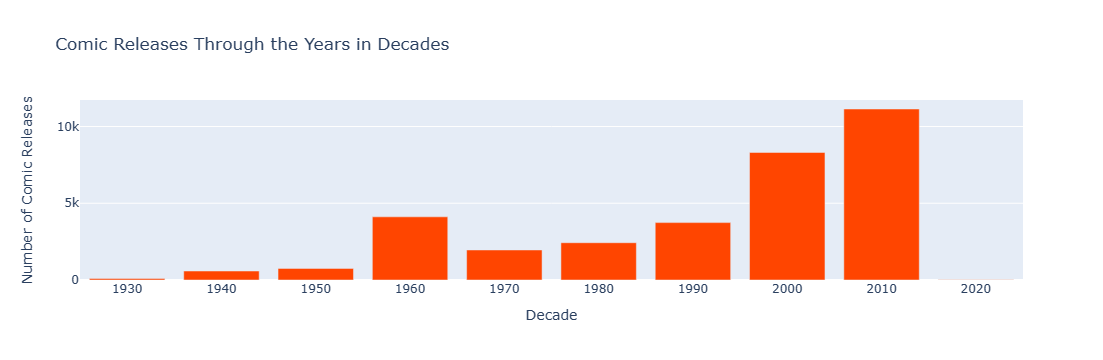

In [11]:
result_df = run_query("""
                MATCH (c:Comic)
                RETURN substring(c.year, 0, 3) + "0" as decade, 
                       count(*) as count
                ORDER BY decade ASC
                                        """)

fig = px.bar(result_df, x='decade', y='count', title='Comic Releases Through the Years in Decades')
fig.update_layout(xaxis_title='Decade', yaxis_title='Number of Comic Releases')
fig.update_traces(marker_color='orangered')
fig.show()

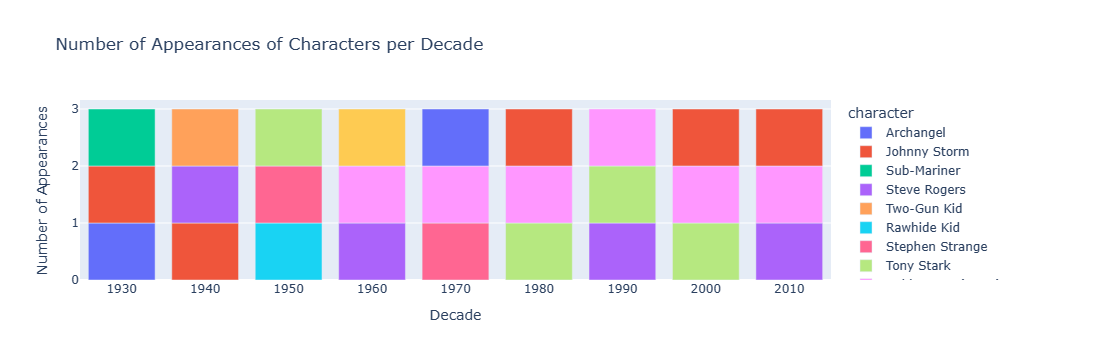

In [24]:
# Top three famous characters through the years

result_df = run_query("""
                            MATCH (c:Comic)<-[:APPEARED_IN]-(c1:Character)
                            WHERE NOT c.year = "null"
                            WITH substring(c.year,0,3) + "0" as decade, 
                                 c1.name as character, 
                                 count(*) as count
                            ORDER BY count DESC
                            RETURN decade, collect(character)[..3] as top_3_characters
                            ORDER BY decade
                                                """)

# Flatten the list of top 3 characters and create a new DataFrame
character_df = pd.DataFrame([(decade, character) for decade, characters in zip(result_df['decade'], result_df['top_3_characters']) for character in characters], columns=['decade', 'character'])

# Count the number of appearances for each character
character_counts = character_df.groupby(['decade', 'character']).size().reset_index(name='num_appearances')



# Plotting
fig = px.bar(character_counts, x='decade', y='num_appearances', color='character',
             title='Number of Appearances of Characters per Decade',
             labels={'num_appearances': 'Number of Appearances', 'decade': 'Decade'},
             category_orders={'decade': ['1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010']})
fig.show()

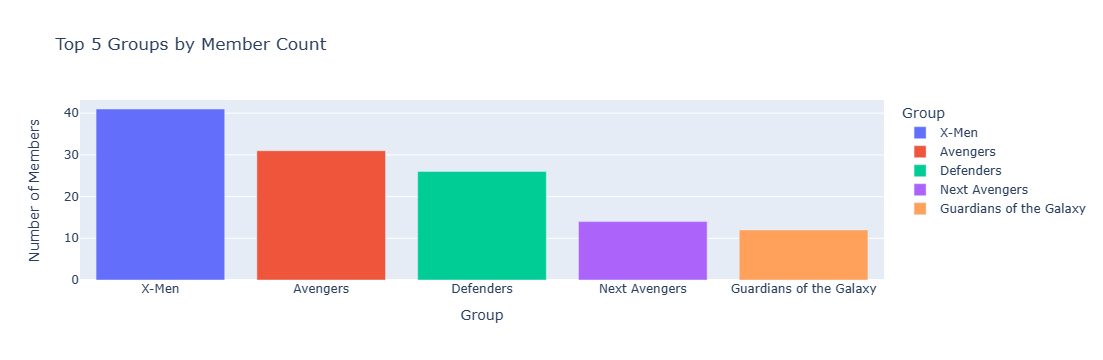

In [31]:
# Biggest groups of characters.

result_df = run_query("""
                        MATCH (g:Group)
                        RETURN g.name as group, 
                               count{ (g)<-[:PART_OF_GROUP]-() } as members
                        ORDER BY members DESC LIMIT 5
                                                """)

fig = px.bar(result_df, x='group', y='members', 
             title='Top 5 Groups by Member Count',
             labels={'members': 'Number of Members', 'group': 'Group'},
             color='group')
fig.show()

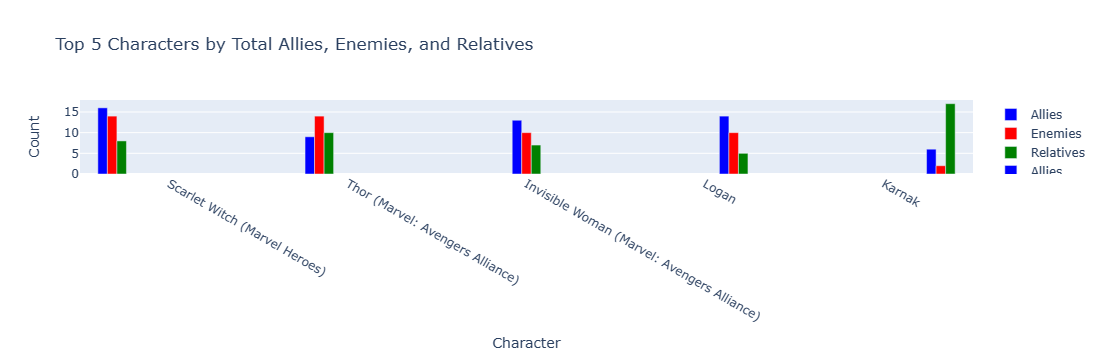

In [81]:
# Degree for each relationship type

result_df = run_query("""
            MATCH (c:Character)
            RETURN c.name as name,
                   count{ (c)-[:ALLY]->() } as allies,
                   count{ (c)-[:ENEMY]->() } as enemies,
                   count{ (c)-[:RELATIVE]->() } as relative
            ORDER BY allies + enemies + relative DESC LIMIT 5 
                                                                """)

fig = go.Figure()

# Add bars for allies, enemies, and relatives for each character
for index, row in result_df.iterrows():
    character = row['name']
    allies = row['allies']
    enemies = row['enemies']
    relatives = row['relative']
    
    fig.add_trace(go.Bar(
        x=[character],
        y=[allies],
        name='Allies',
        marker_color='blue'
    ))
    
    fig.add_trace(go.Bar(
        x=[character],
        y=[enemies],
        name='Enemies',
        marker_color='red'
    ))
    
    fig.add_trace(go.Bar(
        x=[character],
        y=[relatives],
        name='Relatives',
        marker_color='green'
    ))

# Update layout
fig.update_layout(barmode='group',
                  title='Top 5 Characters by Total Allies, Enemies, and Relatives',
                  xaxis_title='Character',
                  yaxis_title='Count')

# Show the plot
fig.show()

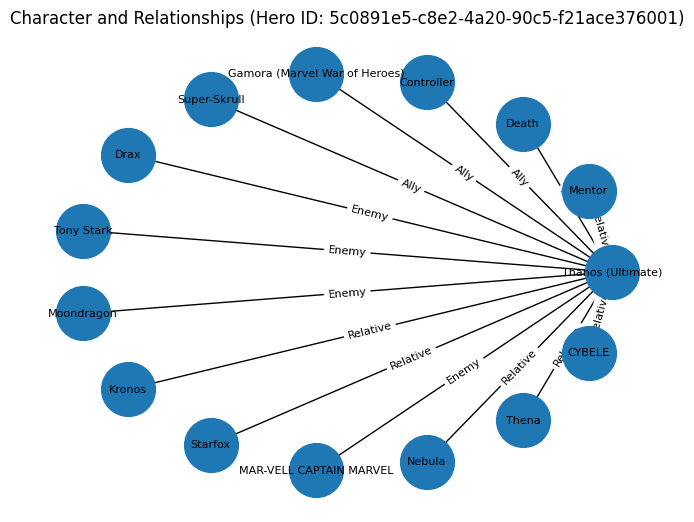

In [113]:
# Define the query with parameters
query = """
MATCH (c:Character {id: $hero_id})
OPTIONAL MATCH (c)-[:ALLY]->(ally)
OPTIONAL MATCH (c)-[:ENEMY]->(enemy)
OPTIONAL MATCH (c)-[:RELATIVE]->(relative)
RETURN c.name as character,
       collect(DISTINCT ally.name) as allies,
       collect(DISTINCT enemy.name) as enemies,
       collect(DISTINCT relative.name) as relatives
"""

# Define the hero ID
hero_id = "5c0891e5-c8e2-4a20-90c5-f21ace376001"

# Execute the query with parameters
result = run_query_with_params(query, {"hero_id": hero_id})

# Check if there's any data
if not result.empty:
    # Extract data from the result
    character_name = result['character'][0]
    allies = result['allies'][0]
    enemies = result['enemies'][0]
    relatives = result['relatives'][0]

    # Create a networkx graph
    G = nx.Graph()

    # Add character node
    G.add_node(character_name, label=character_name, type='Character')

    # Add nodes for allies, enemies, and relatives
    for ally in allies:
        G.add_node(ally, label=ally, type='Ally')
        G.add_edge(character_name, ally, relationship='Ally')

    for enemy in enemies:
        G.add_node(enemy, label=enemy, type='Enemy')
        G.add_edge(character_name, enemy, relationship='Enemy')

    for relative in relatives:
        G.add_node(relative, label=relative, type='Relative')
        G.add_edge(character_name, relative, relationship='Relative')

    # Draw the graph with customizations
    pos = nx.circular_layout(G)  # Change the layout to circular
    nx.draw(G, pos, with_labels=True, node_size=1500, font_size=8)  # Adjust node size and font size
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)  # Adjust edge label font size
    plt.title(f"Character and Relationships (Hero ID: {hero_id})")
    plt.axis('off')  # Remove plot axis
    plt.show()
else:
    print("No data found.")

Degree Centrality:
Thanos (Ultimate): 1.0
Mentor: 0.07142857142857142
Death: 0.07142857142857142
Controller: 0.07142857142857142
Gamora (Marvel War of Heroes): 0.07142857142857142

Closeness Centrality:
Thanos (Ultimate): 1.0
Mentor: 0.5185185185185185
Death: 0.5185185185185185
Controller: 0.5185185185185185
Gamora (Marvel War of Heroes): 0.5185185185185185

Betweenness Centrality:
Thanos (Ultimate): 1.0
Mentor: 0.0
Death: 0.0
Controller: 0.0
Gamora (Marvel War of Heroes): 0.0


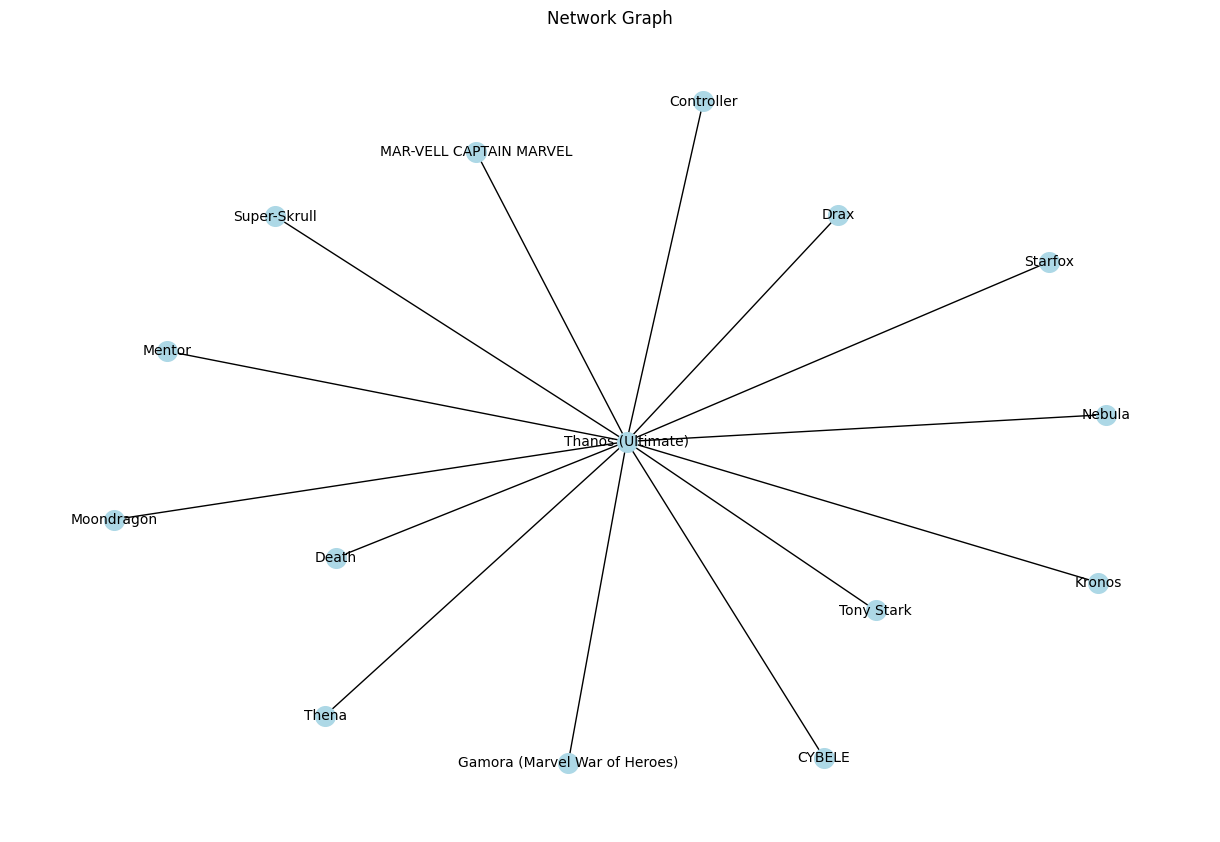

In [115]:
# Define a function to retrieve character data from Neo4j
def get_character_data_from_neo4j():
    with driver.session() as session:
        result = session.run("MATCH (c:Character) RETURN c.id as id, c.name as name, c.aliases as aliases, c.identity as identity")
        character_data = [(record["id"], record["name"], record["aliases"], record["identity"]) for record in result]
    return character_data

# Retrieve character data from Neo4j
character_data = get_character_data_from_neo4j()

# Create a NetworkX graph and add nodes for characters
# G = nx.Graph()
# for character_id, character_name, aliases, identity in character_data:
#    G.add_node(character_id, name=character_name, aliases=aliases, identity=identity, type='Character')

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Print the centrality measures for the first 5 nodes
print("Degree Centrality:")
for node, centrality in list(degree_centrality.items())[:5]:
    print(f"{node}: {centrality}")

print("\nCloseness Centrality:")
for node, centrality in list(closeness_centrality.items())[:5]:
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in list(betweenness_centrality.items())[:5]:
    print(f"{node}: {centrality}")

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=10)
plt.title("Network Graph")
plt.show()

Degree Centrality:
423a200d-9ffc-4f74-a748-3be4e771c346: 0.0
5f4e3b38-f4b5-45e5-adcb-03347afbfe49: 0.0
2ae21c6e-d551-4746-9ce9-32daada7d32f: 0.0
1c02ce63-41d9-4e6e-974e-dd2a5fa1183f: 0.0
67328fa7-4fc4-477f-bfc9-a556b41c9cbb: 0.0

Closeness Centrality:
423a200d-9ffc-4f74-a748-3be4e771c346: 0.0
5f4e3b38-f4b5-45e5-adcb-03347afbfe49: 0.0
2ae21c6e-d551-4746-9ce9-32daada7d32f: 0.0
1c02ce63-41d9-4e6e-974e-dd2a5fa1183f: 0.0
67328fa7-4fc4-477f-bfc9-a556b41c9cbb: 0.0

Betweenness Centrality:
423a200d-9ffc-4f74-a748-3be4e771c346: 0.0
5f4e3b38-f4b5-45e5-adcb-03347afbfe49: 0.0
2ae21c6e-d551-4746-9ce9-32daada7d32f: 0.0
1c02ce63-41d9-4e6e-974e-dd2a5fa1183f: 0.0
67328fa7-4fc4-477f-bfc9-a556b41c9cbb: 0.0


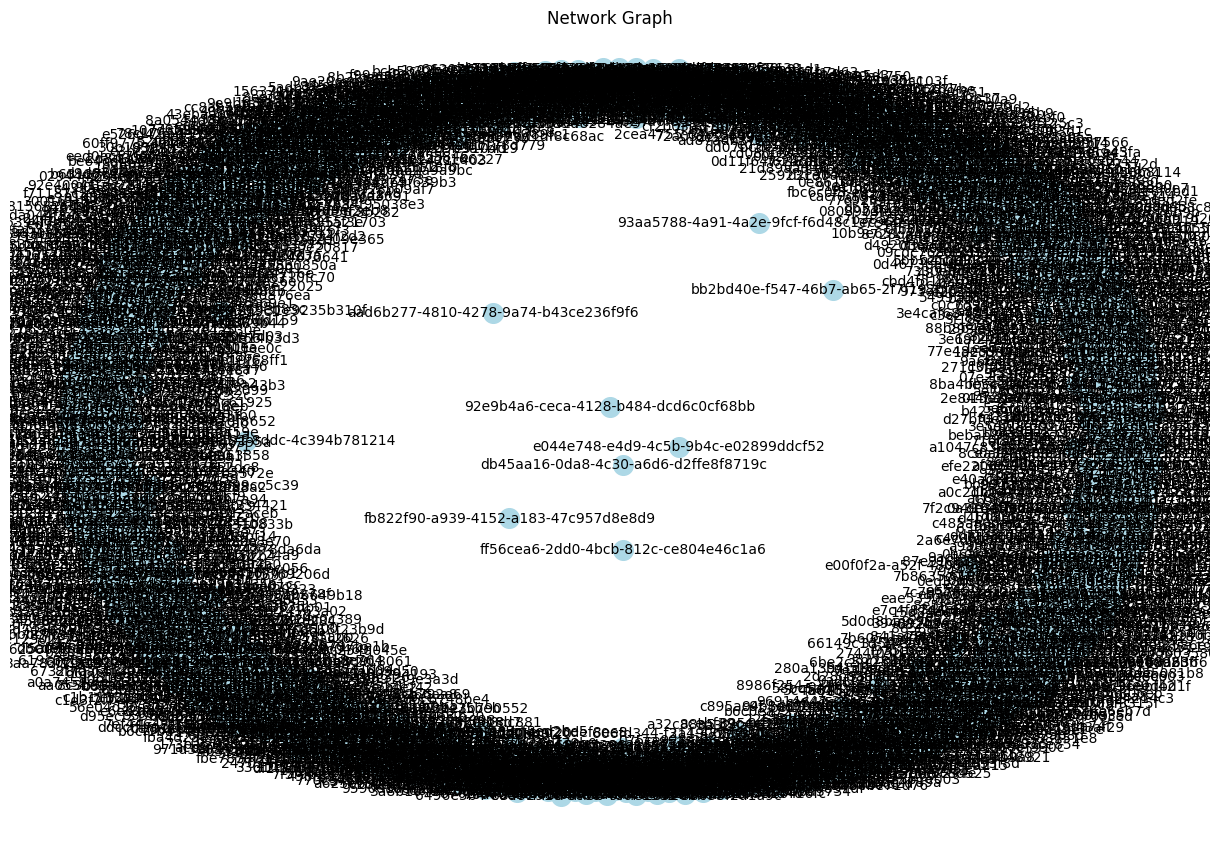

In [116]:
# Define a function to retrieve character data from Neo4j
def get_character_data_from_neo4j():
    with driver.session() as session:
        result = session.run("MATCH (c:Character) RETURN c.id as id, c.name as name, c.aliases as aliases, c.identity as identity")
        character_data = [(record["id"], record["name"], record["aliases"], record["identity"]) for record in result]
    return character_data

# Retrieve character data from Neo4j
character_data = get_character_data_from_neo4j()

# Create a NetworkX graph and add nodes for characters
G = nx.Graph()
for character_id, character_name, aliases, identity in character_data:
   G.add_node(character_id, name=character_name, aliases=aliases, identity=identity, type='Character')

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Print the centrality measures for the first 5 nodes
print("Degree Centrality:")
for node, centrality in list(degree_centrality.items())[:5]:
    print(f"{node}: {centrality}")

print("\nCloseness Centrality:")
for node, centrality in list(closeness_centrality.items())[:5]:
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in list(betweenness_centrality.items())[:5]:
    print(f"{node}: {centrality}")

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=10)
plt.title("Network Graph")
plt.show()

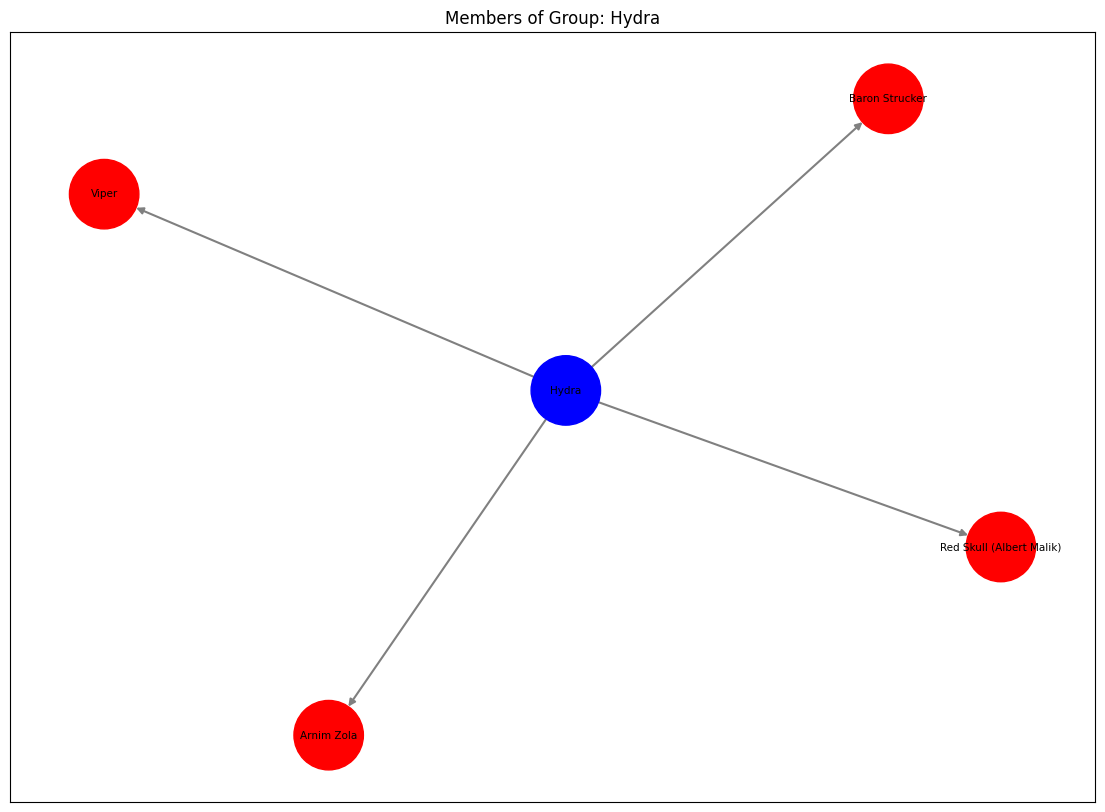

In [66]:
# Get members of a group
def get_group_members(group_name):
    query = f"""
    MATCH (m:Character)-[:PART_OF_GROUP]->(g:Group{{name: '{group_name}'}})
    RETURN g, m
    """
    return run_query(query)

def display_group_members(group_name):
    # Get group members from Neo4j
    result = get_group_members(group_name)
    # Create a directed graph
    G = nx.DiGraph()

    group = result['g']
    member = result['m']
    
    # Add nodes for group and members
    for i in range(0, len(result)):
        G.add_node(group[i]['name'], color='blue')
        G.add_node(member[i]['name'], color='red')
        G.add_edge(group[i]['name'], member[i]['name'])

    # Draw the graph with improved aesthetics
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, seed=42, k=1)  # Adjust k for node separation
    node_colors = [node[1]['color'] for node in G.nodes(data=True)]
    nx.draw_networkx(G, pos, node_color=node_colors, with_labels=True, node_size=2500, edge_color='gray', width=1.5, font_size=7.5)
    plt.title(f'Members of Group: {group_name}')
    plt.show()

# Example usage
group_name = 'Hydra'
display_group_members(group_name)

In [11]:
# Establish connection to the MySQL database
connection = mysql.connector.connect(
        host='127.0.0.1',
        database='bigdata',
        user='root',
        password='MaH$icKL3#mYsICkl3',
        auth_plugin='mysql_native_password'
    )   

# Create a cursor object to execute queries
cursor = connection.cursor()

# Define the SQL query
query = """
    SELECT 
        marvel.name,
        (AVG(heroes.energy) + AVG(heroes.durability) + AVG(heroes.intelligence) + AVG(heroes.strength) + AVG(heroes.fighting_skills) + AVG(heroes.speed)) / 6 AS average_stats
    FROM 
        heroes
    JOIN 
        marvel ON heroes.hero = marvel.id
    GROUP BY 
        marvel.name;
"""

try:
    # Execute the query
    cursor.execute(query)

    # Fetch all the results
    results = cursor.fetchall()

    # Create DataFrame
    df = pd.DataFrame(results, columns=["Name", "Average Stats"])

    # Print DataFrame
    print(df)

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    # Close cursor and connection
    cursor.close()

                                                  Name  Average Stats
0                         MAXWELL "MAX" DILLON ELECTRO       5.333333
1                       EUGENE THOMPSON FLASH THOMPSON       1.833333
2                       NICHOLAS JOSEPH FURY NICK FURY       3.000000
3                             JOHN F. WALKER U.S.AGENT       4.666667
4    TANELEER TIVAN THE COLLECTOR Offbeat alien Tan...       3.666667
..                                                 ...            ...
465                                           Cap'n Oz       2.500000
466                                              Druig       5.500000
467                                      Hindsight Lad       2.000000
468                     Moon Girl (Lunella Layfayette)       3.000000
469                                             Sprite       5.333333

[470 rows x 2 columns]


In [ ]:
cursor = connection.cursor()

try:

    alter_hero_table_query = """
    ALTER TABLE heroes
    ADD COLUMN flight INT
    """
    cursor.execute(alter_hero_table_query)

    # Update the flight column in the hero table
    update_hero_table_query1 = """
    UPDATE heroes h
    JOIN flight f ON h.hero = f.hero
    SET h.flight = CASE WHEN f.flight = 'true' THEN 7 ELSE 0 END
    WHERE h.hero = f.hero;
    """
    cursor.execute(update_hero_table_query1)

    update_hero_table_query2 ="""    
    UPDATE heroes
    SET flight = 0
    WHERE flight IS NULL;
    """
    cursor.execute(update_hero_table_query2)

    # Commit the changes
    connection.commit()

    print("Successfully updated the hero table with flight information.")

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    # Close cursor and connection
    if cursor:
        cursor.close()

                                                  Hero  \
0                         MAXWELL "MAX" DILLON ELECTRO   
1                       EUGENE THOMPSON FLASH THOMPSON   
2                       NICHOLAS JOSEPH FURY NICK FURY   
3                             JOHN F. WALKER U.S.AGENT   
4    TANELEER TIVAN THE COLLECTOR Offbeat alien Tan...   
..                                                 ...   
465                                           Cap'n Oz   
466                                              Druig   
467                                      Hindsight Lad   
468                     Moon Girl (Lunella Layfayette)   
469                                             Sprite   

                                             Neighbors  
0    [Paladin, Darkhawk, Doctor Doom (Ultimate), Li...  
1    [DWAYNE MICHAEL TAYLOR NIGHT THRASHER, Daken, ...  
2    [Bastion, Ka-Zar, Junta, Garrison Kane, Lizard...  
3         [Shatterstar, Triton, Kang, Nuke, Giant Man]  
4    [Maggott, Ars

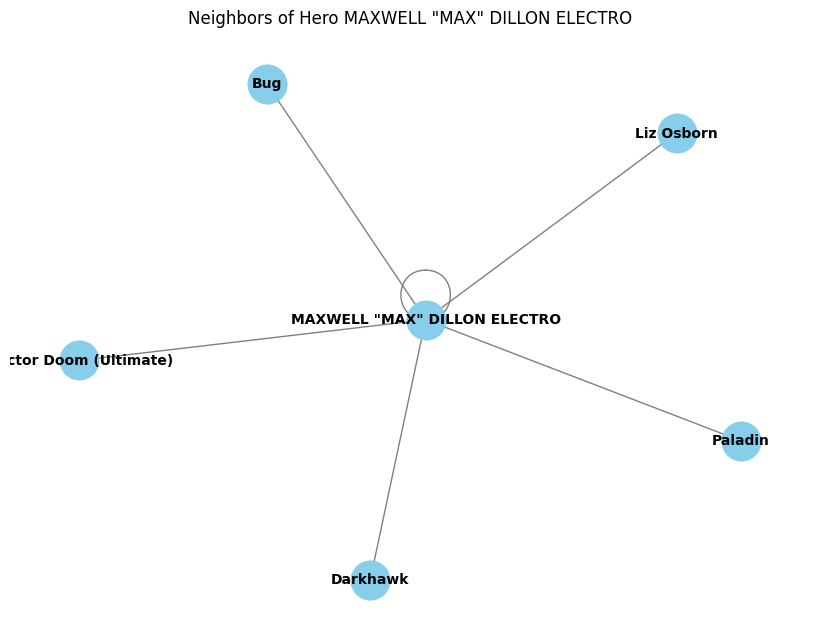

In [8]:
# Establish connection to the MySQL database
connection = mysql.connector.connect(
        host='127.0.0.1',
        database='bigdata',
        user='root',
        password='MaH$icKL3#mYsICkl3',
        auth_plugin='mysql_native_password'
    )   

# Create a cursor object to execute queries
cursor = connection.cursor()

# Define the SQL query to fetch hero data
query_heroes = "SELECT energy, durability, intelligence, strength, fighting_skills, speed, flight FROM heroes"

# Define the SQL query to fetch hero names from marvel
query_hero_names = """
SELECT marvel.name 
FROM marvel 
JOIN heroes ON marvel.id = heroes.hero 
WHERE marvel.name IS NOT NULL
"""

try:
    # Execute the query to fetch hero data
    cursor.execute(query_heroes)
    heroes_data = cursor.fetchall()
    heroes_data_array = np.array(heroes_data).astype(float)

    # Execute the query to fetch hero names
    cursor.execute(query_hero_names)
    hero_names = cursor.fetchall()

    # Close cursor
    cursor.close()

    # Define the kNN model
    k = 5  # Number of neighbors
    knn_model = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='euclidean')

    # Fit the model to the hero data
    knn_model.fit(heroes_data_array)

    # Find the k-nearest neighbors for each hero
    distances, indices = knn_model.kneighbors(heroes_data_array)

    # Create a list to store the data for each hero
    data = []
    
    # Populate the list with hero names and their nearest neighbor names
    for i, hero_indices in enumerate(indices):
        hero_name = hero_names[i][0]
        neighbor_names = [hero_names[idx][0] for idx in hero_indices if idx != i]  # Exclude self
        data.append({'Hero': hero_name, 'Neighbors': neighbor_names})

    # Create a DataFrame from the list of data
    results_df = pd.DataFrame(data)

    # Print the DataFrame
    print(results_df)

    # Create a graph
    G = nx.Graph()

    # Add the hero as a node to the graph
    hero_name = hero_names[0][0]
    G.add_node(hero_name)

    # Add the hero's neighbors as nodes to the graph
    for idx in indices[0]:
        neighbor_name = hero_names[idx][0]
        G.add_node(neighbor_name)
        G.add_edge(hero_name, neighbor_name)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', linewidths=0.5)
    plt.title(f'Neighbors of Hero {hero_name}')
    plt.show()

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    # Close connection
    if connection.is_connected():
        connection.close()

In the context of the k-nearest neighbors (kNN) algorithm applied to hero data, a "neighbor" refers to another hero in the dataset that shares similar characteristics or features with a given hero.

When we say that a hero A is a neighbor of hero B, it means that hero A has similar attribute values to hero B based on the features used for comparison. These features could include attributes such as energy, durability, intelligence, strength, fighting skills, speed, and flight ability.

In [11]:
# Establish connection to the MySQL database
connection = mysql.connector.connect(
        host='127.0.0.1',
        database='bigdata',
        user='root',
        password='MaH$icKL3#mYsICkl3',
        auth_plugin='mysql_native_password'
    )   

# Create a cursor object to execute queries
cursor = connection.cursor()

# Define the SQL query to fetch hero attributes and names from the heroes and marvel tables
query_heroes = """
    SELECT h.hero, h.energy, h.durability, h.intelligence, h.strength, h.fighting_skills, h.speed, h.flight, m.name
    FROM heroes h
    JOIN marvel m ON h.hero = m.id
"""

try:
    # Execute the query to fetch hero attributes and names
    cursor.execute(query_heroes)
    heroes_data = cursor.fetchall()

    # Close cursor
    cursor.close()

    # Create a dictionary to store hero attributes and names
    hero_attributes = {}
    for hero_id, energy, durability, intelligence, strength, fighting_skills, speed, flight, name in heroes_data:
        hero_attributes[hero_id] = {'name': name, 'attributes': [energy, durability, intelligence, strength, fighting_skills, speed, flight]}

    # Calculate Jaccard similarity between pairs of heroes and store the scores in a list
    similarities = []
    heroes_seen = set()  # To keep track of heroes that have already been included
    for hero1, hero2 in combinations(hero_attributes.keys(), 2):
        attr_set1 = set(hero_attributes[hero1]['attributes'])
        attr_set2 = set(hero_attributes[hero2]['attributes'])
        intersection = len(attr_set1.intersection(attr_set2))
        union = len(attr_set1.union(attr_set2))
        jaccard_similarity = intersection / union
        # Add the pair to similarities list only if both heroes are not already seen
        if hero1 not in heroes_seen and hero2 not in heroes_seen:
            similarities.append(((hero1, hero2), jaccard_similarity))
            heroes_seen.update([hero1, hero2])

    # Sort the list of similarities in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Print the top 10 pairs with the highest Jaccard similarity scores
    print("Top 10 hero pairs with highest similarity:")
    for i, (hero_pair, similarity) in enumerate(similarities[:5], 1):
        hero1_name = hero_attributes[hero_pair[0]]['name']
        hero2_name = hero_attributes[hero_pair[1]]['name']
        print(f"{i}. {hero1_name} and {hero2_name} (Jaccard Similarity: {similarity:.2f})")

except mysql.connector.Error as err:
    print("Error:", err)

Top 10 hero pairs with highest similarity:
1. CHTHON and SET (Jaccard Similarity: 1.00)
2. GRAYDON CREED and UNREVEALED; GAEA IS HER GREEK NAME GAEA (Jaccard Similarity: 1.00)
3. Lizard and Spider-Girl (Anya Corazon) (Jaccard Similarity: 0.83)
4. Speed Demon and Spot (Jaccard Similarity: 0.80)
5. Beak and Amphibian (Earth-712) (Jaccard Similarity: 0.75)


In [17]:
query_data = """
    SELECT h.hero, h.energy, h.durability, h.intelligence, h.strength, h.fighting_skills, h.speed, h.flight, m.name
    FROM heroes h
    JOIN marvel m ON h.hero = m.id
"""

try:
    # Read data into a pandas DataFrame
    data = pd.read_sql(query_data, connection)

    # Compute pairwise cosine similarity between heroes based on their attributes
    attributes = data[['energy', 'durability', 'intelligence', 'strength', 'fighting_skills', 'speed', 'flight']]
    similarity_matrix = cosine_similarity(attributes, attributes)

    # Convert the similarity matrix to a DataFrame for easier manipulation
    similarity_df = pd.DataFrame(similarity_matrix, index=data['name'], columns=data['name'])

    # Define a function to recommend heroes based on similarities to a given hero
    def recommend_heroes(hero_name, top_n=5):
        # Get similarities of the given hero with other heroes
        hero_similarity = similarity_df[hero_name].sort_values(ascending=False)[1:top_n+1]
        return hero_similarity

    # Example: Recommend heroes similar to "Iron Man"
    recommendations = recommend_heroes('Wonder Man')
    print("Recommendations for Wonder Man:")
    print(recommendations)

except mysql.connector.Error as err:
    print("Error:", err)

Recommendations for Wonder Man:
name
Tony Stark                                     0.991498
Jubilee (Age of Apocalypse)                    0.990366
Ultron                                         0.990364
Vision                                         0.989778
Invisible Woman (Marvel: Avengers Alliance)    0.989436
Name: Wonder Man, dtype: float64


C:\Users\rrsan\AppData\Local\Temp\ipykernel_13372\1018707065.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query_data, connection)


In [13]:
cursor = connection.cursor()

# Define the SQL query to fetch hero attributes and names from the heroes and marvel tables
query_heroes = """
    SELECT h.hero, h.energy, h.durability, h.intelligence, h.strength, h.fighting_skills, h.speed, h.flight, m.name
    FROM heroes h
    JOIN marvel m ON h.hero = m.id
"""

try:
    # Execute the query to fetch hero attributes and names
    cursor.execute(query_heroes)
    heroes_data = cursor.fetchall()

    # Close cursor
    cursor.close()

    # Create a graph representation of the hero network using NetworkX
    G = nx.Graph()

    # Add nodes (heroes) to the graph with attributes
    for hero_id, energy, durability, intelligence, strength, fighting_skills, speed, flight, name in heroes_data:
        G.add_node(hero_id, energy=energy, durability=durability, intelligence=intelligence, 
                   strength=strength, fighting_skills=fighting_skills, speed=speed, flight=flight, name=name)

    # Calculate Jaccard similarity between pairs of heroes based on their attributes
    num_heroes = len(heroes_data)
    for hero1, hero2 in combinations(range(num_heroes), 2):
        hero1_attrs = set(heroes_data[hero1][1:-1])
        hero2_attrs = set(heroes_data[hero2][1:-1])
        jaccard_similarity = len(hero1_attrs.intersection(hero2_attrs)) / len(hero1_attrs.union(hero2_attrs))
        if jaccard_similarity > 0.84:  # Adjust the threshold as needed
            G.add_edge(heroes_data[hero1][0], heroes_data[hero2][0])  # Add edge between heroes

    # Detect communities using Louvain Modularity algorithm
    communities = community.greedy_modularity_communities(G)

    min_community_size = 5
    communities = [community for community in communities if len(community) >= min_community_size]


    # Print the detected communities
    print("Detected communities:")
    for i, community_nodes in enumerate(communities, 1):
        print(f"\nCommunity {i}: {', '.join(G.nodes[node]['name'] for node in community_nodes)}")


except mysql.connector.Error as err:
    print("Error:", err)

Detected communities:

Community 1: Reaper, Squirrel Girl, Dracula, Onslaught (Ultimate), Captain Universe, Living Tribunal, Deathstrike (Ultimate), Hyperion (Earth-712), GRAYDON CREED, Sasquatch (Walter Langkowski), Eternity, Asylum, CHTHON, Captain Britain (Ultimate), UNREVEALED; GAEA IS HER GREEK NAME GAEA, SET, Bloodscream, Juggernaut

Community 2: Strong Guy, Centennial, Harrier, Titania, Russian, UNREVEALED ANTI-CAP, Doc Samson, Sage, Nekra

Community 3: Death, Tenebrous, Stardust, Black Tom, Multiple Man, Count Nefaria, Namorita, Apocalypse (Ultimate), Thor Girl

Community 4: Wolfsbane (Age of Apocalypse), Richard Fisk, Stature, UNKNOWN ACHEBE, Senator Kelly, Microbe, 3-D Man, EUGENE THOMPSON FLASH THOMPSON

Community 5: Princess Powerful, Microchip, Howard The Duck, Medusa, Phil Coulson (Phil Coulson), Eddie Brock, Alex Wilder

Community 6: The Anarchist, Sauron, Mimic, Whiplash (Mark Scarlotti), Scorpion (Ultimate), Darkhawk, Bug

Community 7: Mr. Fantastic (Ultimate), Elektra

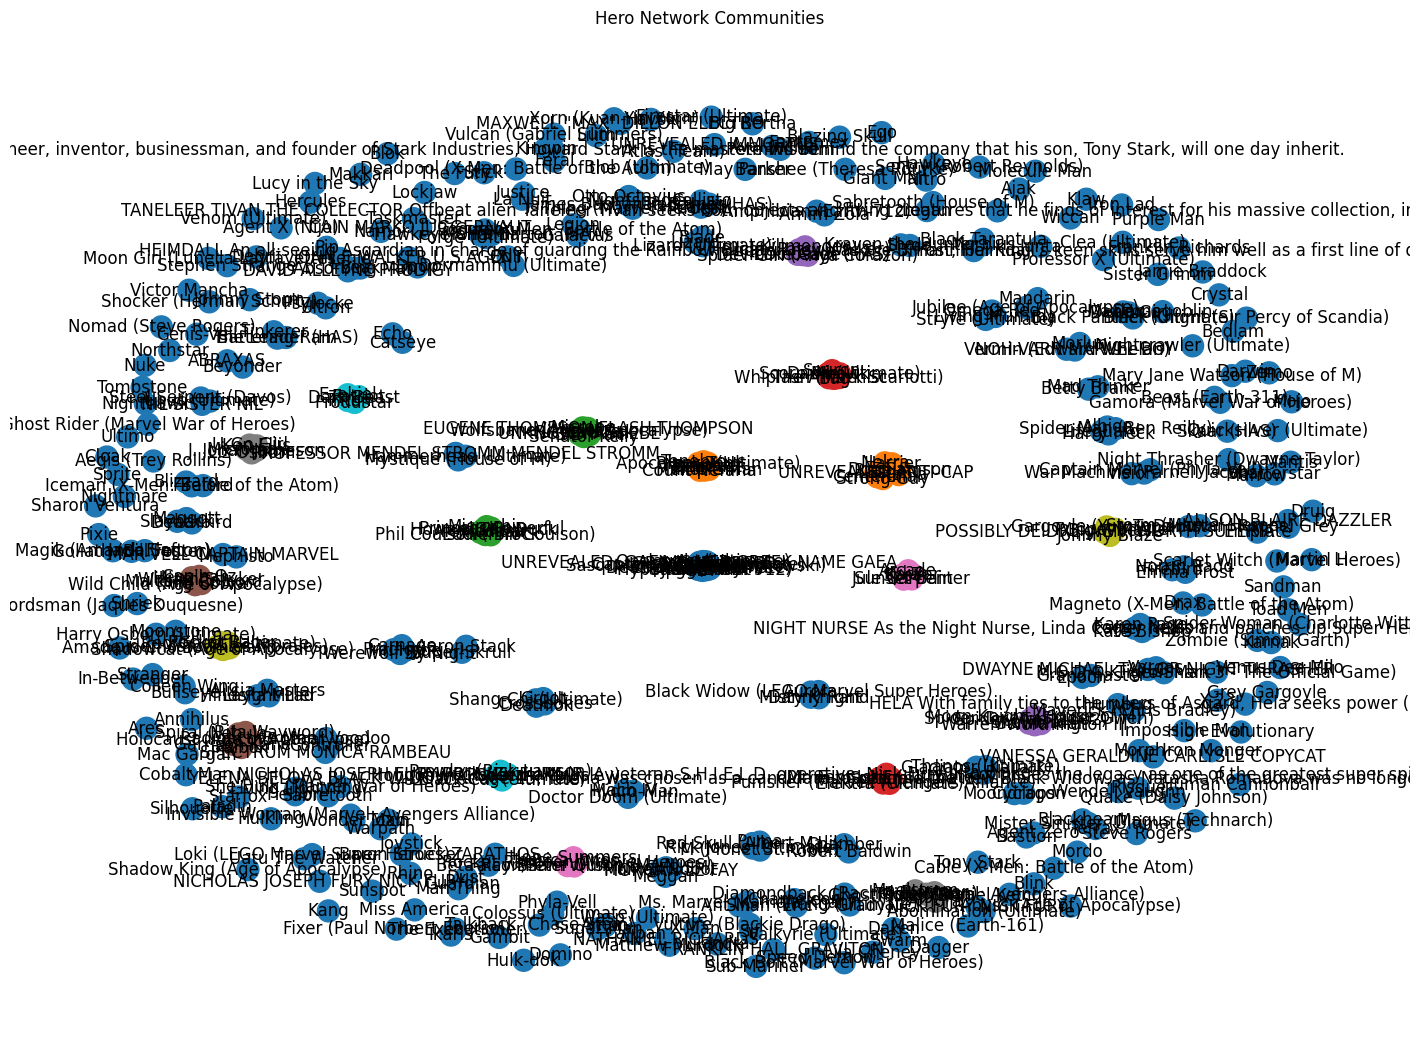

In [26]:
# Create a dictionary mapping hero IDs to community IDs
hero_community_mapping = {}
for i, community_nodes in enumerate(communities, 1):
    for node in community_nodes:
        hero_community_mapping[node] = i

# Define node colors based on community affiliation
node_colors = [hero_community_mapping.get(node, 0) for node in G.nodes()]

# Draw the graph with nodes colored based on community affiliation
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)

# Plot the graph with hero names as labels instead of hero IDs
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, labels={node: G.nodes[node]['name'] for node in G.nodes()}, with_labels=True, node_size=250)

# Adjust font size for node labels
plt.rc('font', size=10)

plt.title('Hero Network Communities')
plt.show()

C:\Users\rrsan\AppData\Local\Temp\ipykernel_11628\4163550637.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


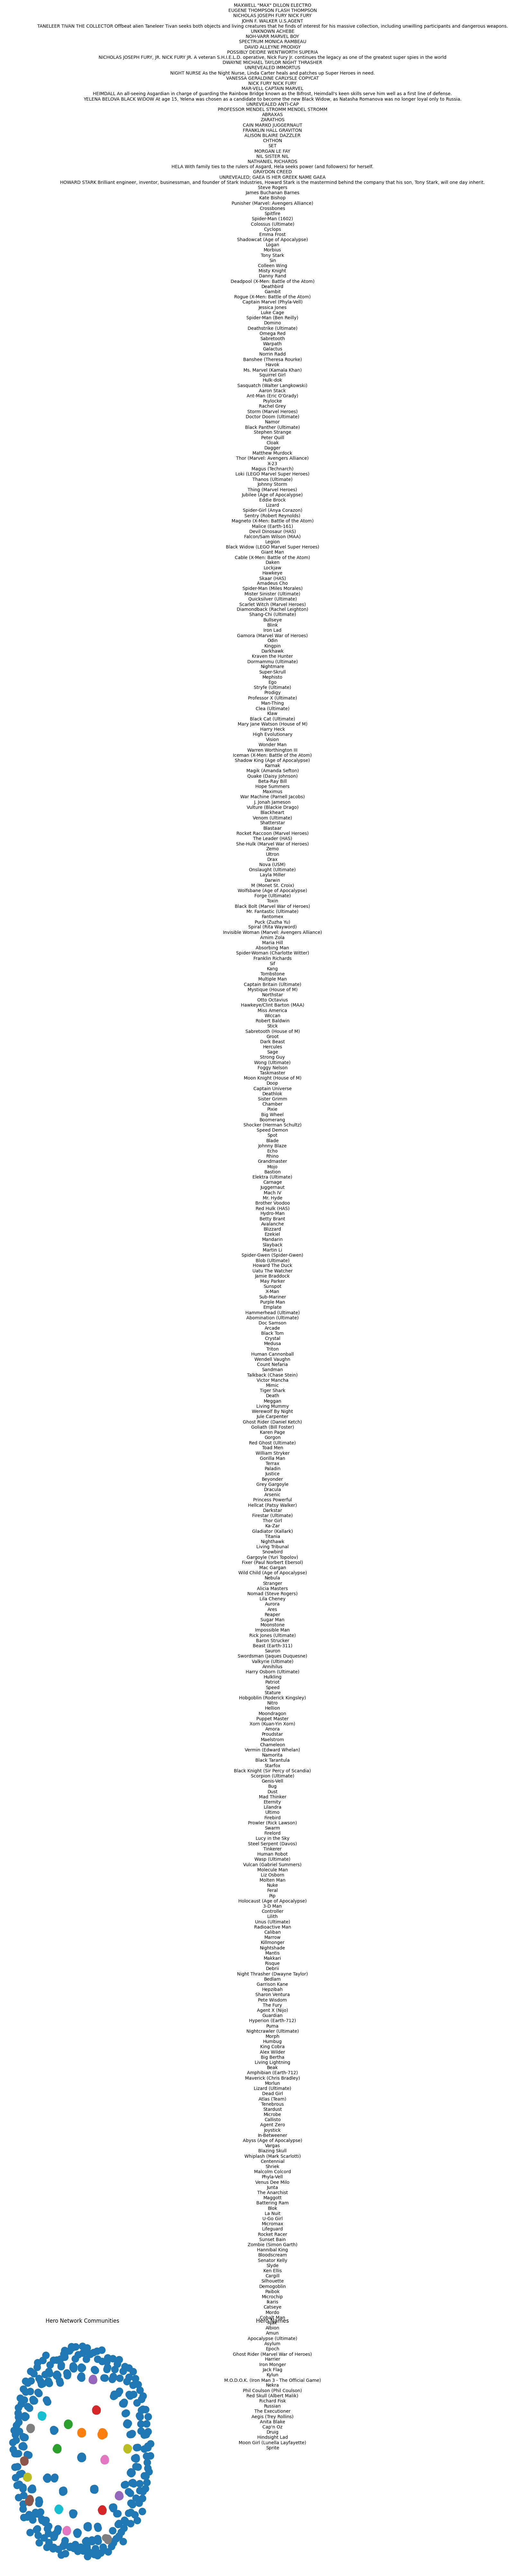

In [27]:
# Draw the graph with nodes colored based on community affiliation
plt.figure(figsize=(14, 10))
plt.subplot(121)

# Plot the graph with hero names as labels instead of hero IDs
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, labels={node: G.nodes[node]['name'] for node in G.nodes()}, with_labels=False, node_size=250)

# Adjust font size for node labels
plt.rc('font', size=10)

plt.title('Hero Network Communities')

# List hero names alongside the graph
plt.subplot(122)
heroes = [G.nodes[node]['name'] for node in G.nodes()]
plt.text(0.5, 0.5, '\n'.join(heroes), fontsize=10, ha='center')
plt.axis('off')
plt.title('Hero Names')

plt.tight_layout()
plt.show()